In [ ]:
import gc
import os
import sys
from os.path import basename
from pathlib import Path
import glob

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from itertools import product
from tkinter import *
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

from tensorflow.keras import backend as K
from xgboost import XGBClassifier

sys.path.append("../")

from helpers.assess import make_classification_report, make_confusion_matrix
from helpers.experiment import experiment
from helpers.split import make_train_test_split, tag_label_feature_split
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

DATASET_FOLDER = os.path.join(Path().absolute().parents[0], "datasets")

**MTG-Jamendo Dataset**

Our project uses  the MTG-Jamendo dataset.

It is built using music available at Jamendo under Creative Commons licenses and tags provided by content uploaders. The dataset contains over 55,000 full audio tracks with 195 tags from genre, instrument, and mood/theme categories.

As we describe in greater detail in our report, we limit our analysis to songs that are identified as belonging to exactly one of ten genres.  We eliminate songs in other genres.  We also eliminate songs labeled as belonging to more than one genre.

After flattening arrays, the dataset includes 2,654 features excluding mel spectrogram data.  We considered several collections of features, for example, one collection included all features in the dataset other than the mel spectrograms, another version consisted of just the mel spectrogram data.  In addition we looked at nine other combinations of features.

https://mtg.github.io/mtg-jamendo-dataset/

**Exploratory Data Analysis -- Class Imbalance**

The genres within the scope of our project are:

+ blues
+ classical
+ country
+ disco
+ hiphop
+ jazz
+ metal
+ genre_pop
+ reggae
+ rock

As noted above, we removed songs from the dataset that were labeled as being in other genres and we removed songs labeled as belonging to more than one of the genres listed above.

The exploratory data analysis that follows is on the version of the dataset that includes all of the features other than mel spectrograms, which we handle separately.  We refer to this dataset as our **all features** dataset.

In [99]:
# Read the data set

df = pd.read_pickle(os.path.join(DATASET_FOLDER, "dataset_00_all.pickle"))

In [100]:
# Get labels, a label encoder and features using a utility function
# we wrote to separate labels and features from the MTG-Jamendo dataset
# and also to discard extraneous metadata.  The code for this function can
# be found in the helpers folder of the project repository.

_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [101]:
# Review the mapping between genre_ids and the genres themselves.

print(f"id genre\n-- -----")
for id, genre in enumerate(le.inverse_transform(range(10))):
    print(f"{id}  {genre[6:]}")

id genre
-- -----
0  blues
1  classical
2  country
3  disco
4  hiphop
5  jazz
6  metal
7  pop
8  reggae
9  rock


Our data is imbalanced.  The pop, classical and rock genres dominate the dataset.  At the other end of the spectrum, blues, country and disco are under represented.  We see this as an artifact of this particular data set only and not reflective of anything more.  Many of the models we worked with provide a parameter that takes into account class imbalance and weights accordingly based on inverse population proportion to enhance the significance of individual data points from under represented classes.  We utitilize that approach when we can.  In some cases, which we describe below, we look to other means to address the imbalance.

In [102]:
genres = pd.DataFrame(le.inverse_transform(y), columns=["genre"]).value_counts()

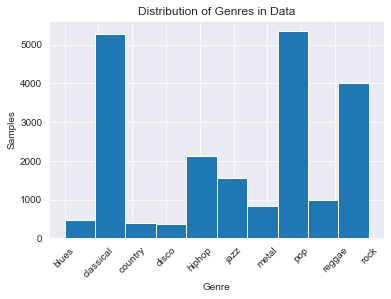

In [103]:
x_labels = [label[6:] for label in le.inverse_transform(range(10))]
plt.hist([y])
plt.title("Distribution of Genres in Data")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.xticks(range(10), x_labels, rotation=45)
plt.show()

As mentioned above, the complete feature set comprises 2,654 features.  We discuss features below.

In [104]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (21351, 2654) y.shape= (21351,)


**Preprocessing**

We set aside 20% of our data for testing and use a stratified split, with shuffling, since we have a multi-class problem. 

In [105]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1962, shuffle=True, stratify=y
)

In [106]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (17080, 2654)	y_train.shape = (17080,)
X_test.shape =  (4271, 2654)	y_test.shape =  (4271,)


In [ ]:
# reconfirm the distribution across the various sets
plt.figure(figsize=(8, 4))
plt.hist([y, y_train, y_test], label=["y", "y_train", "y_test"])
plt.xticks(range(10), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

While some models (such as extreme gradient boost) do not require feature scaling or standardization for best performance, most do.  Morever, principal component analysis and some SMOTE-related sampling approaches also benefit from feature scaling or standardization.  Therefore we apply standardization to our features as a general rule.  

When we work with principal component analysis or SMOTE and SMOTE-related sampling we extended the pre-processing pipeline beyond standardization as the situation warranted.  Our approach to principal component analysis is to use a sufficient number of components to capture 95% of the variance in the underlying data.

As shown below, we are able to capture 95% of the variance in our all features dataset with 387 principal components, a meaningful reduction from the 2,654 components presented in the dataset originally. We will make further use of principal component analysis to visualize our data in the exploratory data analysis included below.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(random_state=1962, n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# review the shapes
print(f"{X_train_scaled.shape = }\t{y_train.shape = }")
print(f"{X_test_scaled.shape  =  }\t {y_test.shape =  }")
print(f"{X_train_pca.shape    = }\t{y_train.shape = }")
print(f"{X_test_pca.shape     =  } \t {y_test.shape =  }")

**Exploratory Data Analysis -- Features**

Machine learning work on audio typically relies on various features extracted from the underlying audio signal.  The signal processing involved is complex and a meaningful discussion is well beyond the scope of this project.

There are a few fundamental concepts that we want to touch on nevertheless.

We begin with spectrograms.  A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.  Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time. See [this article](https://pnsn.org/spectrograms/what-is-a-spectrogram) presented by the Pacific Northwest Seismic Network.  

Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same.  In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.  A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.  See [this article](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) appearing on medium.com

So, it is most common today to start with the spectrogram representation of an audio signal and convert that to a spectrogram on the mel scale, a mel spectrogram.  Some models, like our CNN model, work directly from the mel spectrogram.  In other cases, people derive useful features from the mel spectrogram.

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.  Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This very brief summary is based on [this summary](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) appearing on wikipedia.

Many music genre classification models rely to a large degree on MFCCs.  To that end, we paid attention to MFCC data available to us in the dataset.  In particular, the values of thirteen MFCC coefficients, as well as MFCC related variance, covariance and inverse covariance data points presented in the dataset.

We also ran a series of statistical tests to identify features in the dataset that appear to have statistically meaningful relationships to the various genres.  We then ranked their overall statistically meaningfulness by combining their ranking from individual genres. We identified the top ten features using a p-value driven approach:

![p-value ranking](p_val.png)
  


**Exploratory Data Analysis -- Features -- Principal Component Analysis**

With so many features and classes, we struggled to visualize our data before building our models.  We found that principal component analysis gave us a perspective on the richness and complexity of our data.

The following plot illustrates the ability of PCA to capture information in order to reduce dimensionality.

The plots resuling from the application of PCA to our other dataset variations were not meaningfully different than what we show for our all features dataset.

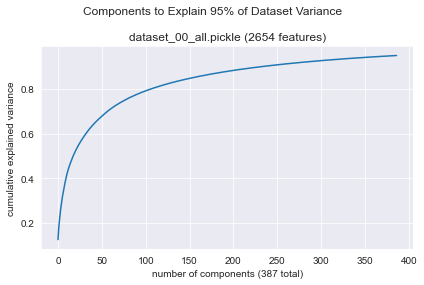

In [14]:
dataset = "../../datasets/dataset_00_all.pickle"
fig, ax = plt.subplots()
fig.suptitle("Components to Explain 95% of Dataset Variance")

original_features = X_train.shape[1]

ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title(f"{basename(dataset)} ({original_features} features)")
ax.set(
    xlabel=f"number of components ({pca.components_.shape[0]} total)",
    ylabel="cumulative explained variance",
)

plt.tight_layout()
plt.show()
fig.savefig("pca-slide-1.png")

The following two dimensional scatter plot shows our dataset viewed through the lens of just the first two principal components.  While some genres appear to be more readily discernible, others are not.  Separating out this dataset has been challenging and this plot starts to give us a sense of why.

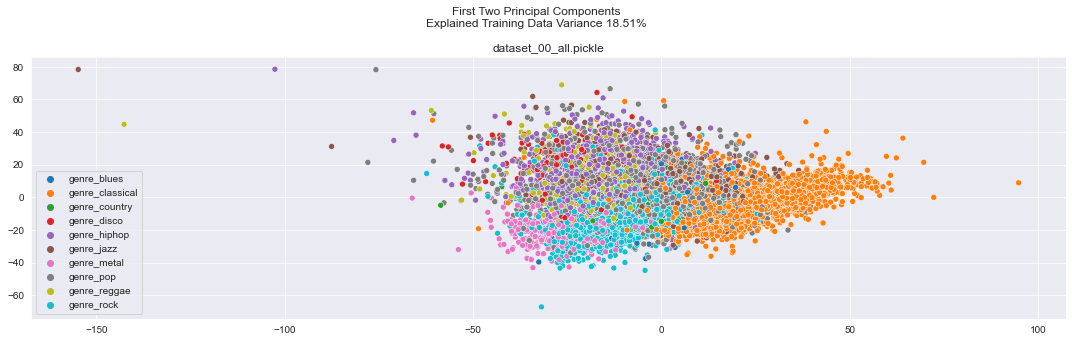

In [15]:
pca_2 = PCA(n_components=2)

# Fit PCA with training features only

X_train_pca_2 = pca_2.fit_transform(X_train_scaled)
X_test_pca_2 = pca_2.transform(X_test_scaled)

# Concatenate test and train data for visualization only

X_pca_2 = np.concatenate((X_train_pca, X_test_pca), axis=0)
y_merged = np.concatenate((y_train, y_test), axis=0)

explanation_ratio = round(sum(pca_2.explained_variance_ratio_[0:2]) * 100, 2)

fig, ax_2d = plt.subplots(figsize=(15, 4.8))
fig.suptitle(
    f"First Two Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)

hue_order = list(le.inverse_transform(range(10)))

sns.scatterplot(
    x=X_pca_2[:, 0],
    y=X_pca_2[:, 1],
    hue=le.inverse_transform(y_merged),
    hue_order=hue_order,
    ax=ax_2d,
    cmap=cmap,
).set(title=basename(dataset))


plt.tight_layout()
plt.show()
fig.savefig("pca-slide-2.png")

We wanted to see if adding a third component to the mix might make it easier to separate our classes.  The following three dimensional scatterplot was the result.  Again, this is on our all features dataset.  When we applied this methodology to other renditions of our dataset we did not see anything meaningfully different.  In some cases the data looked reasonably similar to the plot we show below.  In other cases, the data was even more condensed.

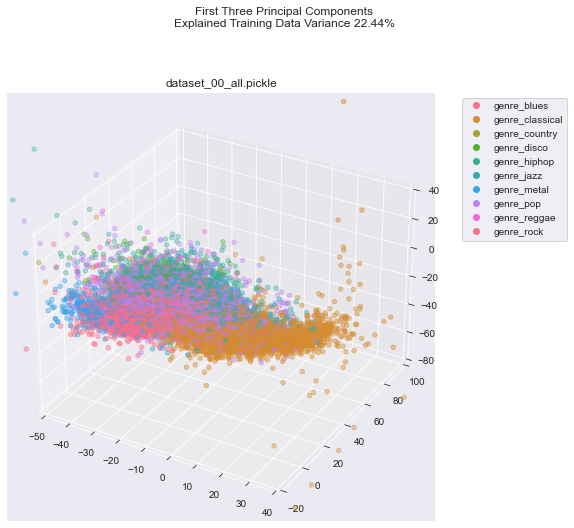

In [16]:
pca_3 = PCA(n_components=3)

# Fit PCA with training features only

X_train_pca_3 = pca_3.fit_transform(X_train_scaled)
X_test_pca_3 = pca_3.transform(X_test_scaled)

# Concatenate test and train data for visualization only

X_pca_3 = np.concatenate((X_train_pca_3, X_test_pca_3), axis=0)
y_merged = np.concatenate((y_train, y_test), axis=0)

explanation_ratio = round(sum(pca_3.explained_variance_ratio_[0:3]) * 100, 2)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

fig.suptitle(
    f"First Three Principal Components\nExplained Training Data Variance {explanation_ratio}%"
)


pca_3_1 = X_pca_3[:, 0]
pca_3_2 = X_pca_3[:, 1]
pca_3_3 = X_pca_3[:, 2]


scatter = ax.scatter(pca_3_1, pca_3_2, pca_3_3, c=y_merged, cmap=cmap)
plt.legend(
    scatter.legend_elements()[0],
    list(le.inverse_transform(range(10))),
    bbox_to_anchor=(1.05, 1),
    loc=2,
)

ax.set_title(basename(dataset))
ax.set_xlim(-50, 40)
ax.set_ylim(-20, 100)
ax.set_zlim(-80, 40)
plt.tight_layout()
plt.show()
fig.savefig("pca-slide-3.png")

___

**Model Review -- Extreme Gradient Boost**

We built a classifier using Extreme Gradient Boost.

Unlike many models available to us, the Extreme Gradient Boost software we had does not include a way to specify that class imbalance should be handled by supplying class weights.  Weighting is available for binary classifiers but not for imbalanced data sets involving more than two classes.

We began with a default extreme gradient boost model and ran it against our collection of datasets, both with and without principal component analysis as well as various permutations of SMOTE resampling.  While the best results were with our all features dataset, the results were very disappointing in all circumstances.

Eventually, we created a balanced set of data using random undersampling.  With our balanced dataset in hand, the Extreme Gradient Boost models began to perform reasonably well.  Based on our prior work, we decided to use the all features dataset for this purpose.  We note that using principal components did not provide any benefits.

Extreme Gradient Boost has a relatively complex set of hyperparamters.  Using gridsearch to explore the hyperparamter space in a brute force fashion is very inefficient.  So, we turned to a Bayesian Optimization package.

>Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.  The package, with documentation and examples is maintained [here](https://github.com/fmfn/BayesianOptimization).

The hyerparameters we use in our model result from the use of the Bayesian optimization process.

As we worked to build models we realized that one of the biggest challenges we faced is that the pop genre is difficult to classify (we had a hint of this when looking at the scatterplots shown above).  So, the most heavily represented genre in our dataset turns out to be very hard to classify.  

In [17]:
# read a data set
dataset = "dataset_00_all.pickle"
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [18]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [19]:
# undersample to create balanced dataset
rus = RandomUnderSampler(random_state=1962)
X_res, y_res = rus.fit_resample(X, y)

In [20]:
# confirm the number of samples of each class
np.unique(y_res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([361, 361, 361, 361, 361, 361, 361, 361, 361, 361], dtype=int64))

In [21]:
# split into train/validation and test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_res, y_res, test_size=0.2, shuffle=True, stratify=y_res, random_state=1962
)

In [22]:
# split training/validation into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    shuffle=True,
    stratify=y_train_val,
    random_state=1962,
)

In [23]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
# build and train the model

classifier = XGBClassifier(
    learning_rate=0.181088,
    n_estimators=419,
    max_depth=3,
    gamma=0.174787,
    reg_alpha=0.4416,
    use_label_encoder=False,
    tree_method="gpu_hist",  # if running on a machine without a GPU comment out this line
    sampling_method="gradient_based",
    objective="multi:softprob",
    eval_metric=["mlogloss", "auc"],
    early_stopping_rounds=10,
    seed=1962,
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
classifier.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

[20:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [20:56:40] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

Lets confirm that our data is now balanced.

In [ ]:
class_count = len(le.classes_)
x_labels = [label[6:] for label in le.inverse_transform(range(class_count))]
plt.figure(figsize=(8, 4))
plt.hist(
    [y_res, y_train, y_val, y_test],
    label=["y (undersampled)", "y_train", "y_val", "y_test"],
)
plt.xticks(range(class_count), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train, Validation and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

**Training and Evaluation Curves**

We ended up tuning most of the model parameters away from their defaults, including L1 regularization.  L2 regularization changes did not have a meaningful impact.  We also made use of early stopping.

In [ ]:
# get training and validation results from the classifier
classifier_results = classifier.evals_result()

train_results = classifier_results["validation_0"]
validation_results = classifier_results["validation_1"]

In [ ]:
# generate predictions on the test dataset
test_predictions = classifier.predict(X_test_scaled)

In [ ]:
test_predictions = classifier.predict(X_test_scaled)

In [ ]:
plt.plot(train_results["mlogloss"], label="train")
plt.plot(validation_results["mlogloss"], label="validate")
plt.title("training")
plt.xlabel("epoch")
plt.ylabel("mlogloss")
plt.legend()
plt.show()

In [ ]:
plt.plot(train_results["auc"], label="train")
plt.plot(validation_results["auc"], label="validate")
plt.title("evaluation")
plt.xlabel("epoch")
plt.ylabel("ROC AUC")
plt.legend()
plt.show()

**Model performance on test data**

As shown below, this model achieves an mcc score of .594 on the test data and a class balanced accuracy of 63.2%.

As evident from the classification report and confusion matrix, each as shown below, the model has very uneven performance across genres.  As mentioned above, the most challenging genres for this model are blues and pop.  On the other hand, the most successful genres are classical and metal.  When we think about the nature of music, those results are not surprising; blues and pop are very wide ranging with a great deal of overlap with other genres.  Classical and metal are more distinctive.

In [ ]:
matthews_corrcoef(y_test, test_predictions)

In [ ]:
balanced_accuracy_score(y_test, test_predictions)

In [ ]:
make_classification_report(
    y_test, test_predictions, label_encoder=le, print_report=True
)
pass

In [ ]:
make_confusion_matrix(y_test, test_predictions, label_encoder=le, title=dataset)
pass

Memory control

In [ ]:
del df
del dataset
del X
del y
del X_res
del y_res
del X_val
del y_val
del X_train_val
del y_train_val
del scaler
del X_train_scaled
del X_val_scaled
del X_test_scaled
del classifier
del eval_set
del x_labels
del classifier_results
del train_results
del validation_results
del test_predictions

gc.collect()

---

**Model Review -- Convolutional Neural Net**

We also built a Convolutional Neural Net model using the mel spectrogram version of our dataset.  This dataset consists solely of the mel spectrogram representation of the audio being sampled without any additional feature extraction.

The samples in our dataset do not have a uniform length.  To address that and to manage the size, we exracted a thirty second segment from the middle of each sample.

We began with a simple random CNN model with one Conv2D layer and one MaxPool2D layer. This model performed poorly with accuracy hovering around 20%.  The loss curve was volative and difficult to tune.

The application of CNN to music genre classification is the topic of many research articles. We reviewed relevant literature to help us build our model.  We worked from the model described in [this article](https://towardsdatascience.com/music-genre-recognition-using-convolutional-neural-networks-cnn-part-1-212c6b93da76) to jump start our baseline CNN model. 

Unfortunately, using the center cropped 30s mel spectrogram dataset on the baseline model was not satisfactory. The loss curve suggested that the model need more sample data. By partitioning the center cropped 30 second data into 10 three second chunks, we significantly improved the model's performance. After fine tuning, the model was able to reach test data balanced accuracy of 56% with the classical genre at about 89 accuracy%.

Even though the validation loss curve volatility was less than with our first model, it continued to exist at an unsatisfactory level. Moreover, the training loss curve continued to decrease while the validation loss curve hit a plateau. We attribute this to noise in our data and the imbalance in our dataset.

To further address the volatile accuracy and loss curves, we used under sampling to run this model on a balanced dataset, using the same approach we took for extrement gradient boost.  The balanced accuracy dropped by about one percent but both mcc and macro average f1 improved.  The accuracy and loss curve volatility also improved, suggesting additional fine tuning could produce better results.  We believe that additional samples would help.

As discussed above, we recognize that what constitutes "pop" music varies over time and that there is significant overlap between the pop music genre and others. And, our imbalanced data set is dominated be the genre we find most difficult genre to classify.  With that in mind we removed the pop genre from the dataset and ran a balanced version of that dataset on our model.  When we did that, balanced accuracy increased to 61.2%, macro average f1 increased to .60 and mcc increased to .56.

In [ ]:
def split10(array):
    return np.array_split(array[:, 0:680], 10, axis=1)


def partition(df, shuffle=True):
    df["melspec"] = df["melspec"].apply(split10)
    df = df.explode(["melspec"]).reset_index(drop=True)
    if shuffle:
        df = df.sample(frac=1)  # shuffle

    return df


def transformData(X):
    # extract 2D numpy array from pandas dataframe
    X = np.array(list(X.to_numpy()[:, 0]))

    scaler = StandardScaler()
    # flatten 2D array to fit to "overall" mean / variance
    scaler.fit(X.reshape(-1, 1))
    # must be reshaped for transformation then restored to original shape
    X = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

    # add a dimension from (n, 96, 68) to (n, 96, 68, 1)
    X = np.expand_dims(X, axis=-1)

    return X


def get_f1(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


def same_prepare_process(df, balanced=False):
    df = partition(df)

    _, (y, le), X = tag_label_feature_split(df, label_format="encoded")

    if balanced:
        rus = RandomUnderSampler(random_state=1962)
        X, y = rus.fit_resample(X, y)

    X = transformData(X)

    X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.2, random_state=1962, stratify=y
    )

    X_train, X_validation, y_train, y_validation = make_train_test_split(
        X_train, y_train, test_size=0.25, random_state=1962, stratify=y_train
    )

    class_weight = {
        i: c
        for i, c in enumerate(
            compute_class_weight(
                class_weight="balanced", classes=le.transform(le.classes_), y=y_train
            )
        )
    }

    del X
    del y

    gc.collect()

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        X_validation,
        y_validation,
        class_weight,
        le,
    )


def accuracy_and_loss_curve(hist):
    history = hist.history

    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history["loss"], lw=2, color="darkgoldenrod")
    plt.plot(history["val_loss"], lw=2, color="indianred")
    plt.legend(["Train", "Validation"], fontsize=10)
    ax.set_xlabel("Epochs", size=10)
    ax.set_title("Loss")

    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history["accuracy"], lw=2, color="darkgoldenrod")
    plt.plot(history["val_accuracy"], lw=2, color="indianred")
    plt.legend(["Train", "Validation"], fontsize=10)
    # plt.ylim(0.7,0.8)
    ax.set_xlabel("Epochs", size=10)
    ax.set_title("accuracy")

    print(
        "After fine-tuning this model, evaluation on the validation data shows an accuracy of:",
        np.round(history["val_accuracy"][-1] * 100, 2),
        "%",
    )

**Imbalanced All Genres Dataset**

In [ ]:
# reading dataset
dataset = "dataset_10_melspecs.pickle"
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [ ]:
# partition each song into 10 chuncks
df = partition(df)

In [ ]:
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

del df

In [ ]:
X = transformData(X)

In [ ]:
X_train, X_test, y_train, y_test = make_train_test_split(
    X, y, test_size=0.2, random_state=1962, stratify=y
)

X_train, X_validation, y_train, y_validation = make_train_test_split(
    X_train, y_train, test_size=0.25, random_state=1962, stratify=y_train
)

class_weight = {
    i: c
    for i, c in enumerate(
        compute_class_weight(
            class_weight="balanced", classes=le.transform(le.classes_), y=y_train
        )
    )
}

del X
del y

Lets examine some mel spectrograms for each genre

In [ ]:
for l in range(10):
    nrows, ncols = 1, 5  # print first 4 images
    f, axs = plt.subplots(nrows, ncols, figsize=(17, 5))
    tempArr = X_train[y_train == l, :]
    label = le.inverse_transform([l])[0]
    num = 0
    for i in range(ncols):
        img = librosa.display.specshow(
            np.squeeze(tempArr[num], axis=-1),
            x_axis="time",
            y_axis="mel",
            sr=12000,
            fmax=10000,
            ax=axs[i],
        )
        axs[i].set(title=label)
        num += 1
    plt.show()

Lets build the model

In [ ]:
def build_model(
    filters=[16, 32, 64, 128],
    kernal_size=[(3, 3), (3, 3), (3, 3), (3, 3)],
    strides=(1, 1),
    padding="same",
    activation="relu",
    pool_size=(2, 2),
    batch_axis=[3, 3, -1, -1],
    dropout_rate=[0.3, 0.3, 0.3, 0.3],
    input_shape=(None, 96, 68, 1),
    last_activation="softmax",
    genres=10,
):
    model = tf.keras.Sequential()

    for i in range(len(filters)):
        model.add(
            tf.keras.layers.Conv2D(
                filters=filters[i],
                kernel_size=kernal_size[i],
                strides=strides,
                padding=padding,
                name=f"conv_{i}",
                activation=activation,
            )
        )

        tf.keras.layers.BatchNormalization(batch_axis[i])

        model.add(tf.keras.layers.MaxPool2D(pool_size=pool_size, name=f"pool_{i}"))

        model.add(tf.keras.layers.Dropout(rate=dropout_rate[i], name=f"dropout_{i}"))

    model.add(tf.keras.layers.Flatten())

    model.add(
        tf.keras.layers.Dense(units=genres, name="fc_last", activation=last_activation)
    )

    tf.random.set_seed(1)
    model.build(input_shape=input_shape)
    print(model.summary())

    return model

In [ ]:
model = build_model()

In [ ]:
learning_rate = 0.00055
epoch = 100

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate, decay_steps=50000, decay_rate=0.96,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", get_f1],
)

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch,
    validation_data=(X_validation, y_validation),
    class_weight=class_weight,
    verbose=0,
)

Accuracy and Loss Curves

After careful hyper parameter tuning in general, we found that neither L1 or L2 regularization helped with overfitting. Smaller learning rates helped.

In [ ]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history["loss"], lw=2, color="darkgoldenrod")
plt.plot(history["val_loss"], lw=2, color="indianred")
plt.legend(["Train", "Validation"], fontsize=10)
ax.set_xlabel("Epochs", size=10)
ax.set_title("Loss")

ax = fig.add_subplot(1, 3, 2)
plt.plot(history["accuracy"], lw=2, color="darkgoldenrod")
plt.plot(history["val_accuracy"], lw=2, color="indianred")
plt.legend(["Train", "Validation"], fontsize=10)
# plt.ylim(0.7,0.8)
ax.set_xlabel("Epochs", size=10)
ax.set_title("accuracy")

print(
    "After fine-tuning this model, evaluation on the validation data shows an accuracy of:",
    np.round(history["val_accuracy"][-1] * 100, 2),
    "%",
)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
balanced_accuracy_score(y_test, y_pred)

In [ ]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

In [ ]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass

Balanced Accuracy: 0.56 \
MCC: 0.42 \
Macro Average f1: 0.41

**Balanced All Genres Dataset (Under Sampling)**

In [ ]:
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    X_validation,
    y_validation,
    class_weight,
    le,
) = same_prepare_process(df, balanced=True)

In [ ]:
model = build_model(genres=10)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", get_f1],
)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch,
    validation_data=(X_validation, y_validation),
    class_weight=class_weight,
    verbose=0,
)

Lets examine the accuracy and loss curve again

In [ ]:
accuracy_and_loss_curve(hist)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
balanced_accuracy_score(y_test, y_pred)

In [ ]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

In [ ]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass

Balanced Accuracy: 0.54 \
MCC: 0.50 \
Macro Average f1: 0.54

Looking at the balanced model, we can see that even though the curve are less volatile, which sugeests that given a larger dataset, we should be able to further fine tune the model and have better performance.

**Balanced w/o Pop Genre**

In [ ]:
# reading dataset
dataset = "dataset_10_melspecs_no_pop.pickle"
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [ ]:
print(df.columns)

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    X_validation,
    y_validation,
    class_weight,
    le,
) = same_prepare_process(df, balanced=True)

In [ ]:
model = build_model(genres=9)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", get_f1],
)
hist = model.fit(
    X_train,
    y_train,
    epochs=epoch,
    validation_data=(X_validation, y_validation),
    class_weight=class_weight,
    verbose=0,
)

Lets examine the accuracy and loss curve again

In [ ]:
accuracy_and_loss_curve(hist)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
balanced_accuracy_score(y_test, y_pred)

In [160]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.13    0.45      0.20       94  0.21
  genre_classical       0.79    0.84      0.81     1055  0.75
    genre_country       0.25    0.50      0.34       82  0.34
      genre_disco       0.21    0.79      0.33       72  0.39
     genre_hiphop       0.61    0.66      0.64      425  0.60
       genre_jazz       0.47    0.57      0.52      311  0.48
      genre_metal       0.42    0.75      0.54      166  0.54
        genre_pop       0.65    0.28      0.39     1069  0.32
     genre_reggae       0.48    0.63      0.55      197  0.53
       genre_rock       0.67    0.46      0.55      800  0.48
                                                             
         accuracy                         0.56     4271  0.50
        macro avg       0.47    0.59      0.49     4271      
     weighted avg       0.63    0.56      0.56     4271      
        

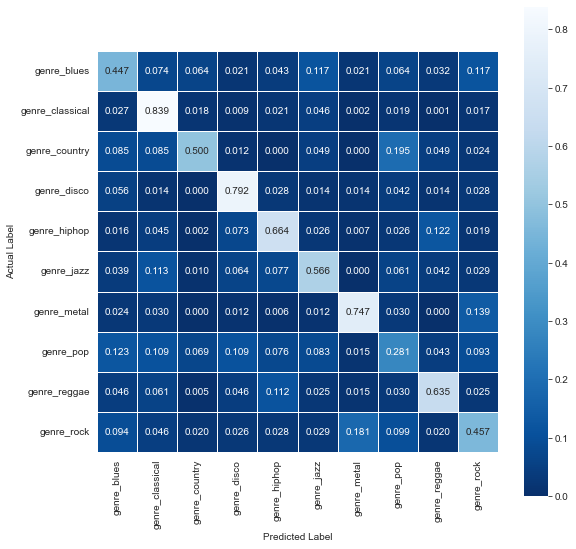

In [152]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass

Balanced Accuracy: 0.61 \
MCC: 0.56 \
Macro Average f1: 0.60

Memory control

In [ ]:
del df
del dataset
del X_validation
del y_validation
del model
del lr_schedule
del hist
del history
del y_pred

gc.collect()

# Support Vector Machines (SVM)

We also created a support vector machine model (SVM), given the strong results from existing literature. The data used was pre-processed in the same manner as the prior models. We do not attempt to address sample imbalance by undersampling or oversampling.

The SVM is a prime candidate for pattern classification as well as nonlinear regression. Essentially, the main idea of SVM is to construct a hyperplanse that acts as the decision surface such that the margin of separation between positive and negative samples is maximized.

We explore hyperparameter tuning by leveraging GridSearch, but finding better results, and explore a variety of kernels including linear, polynomial, and sigmoid.

Overall, within SVM, we found that hypertuning 


In [163]:
#gathering the data and putting it into a dataframe
df = pd.read_pickle(os.path.join(DATASET_FOLDER, dataset))

In [109]:
# split training/validation into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    shuffle=True,
    stratify=y_train_val,
    random_state=1962,
)

In [164]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [167]:
#Creating the SVM model
clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")


Train accuracy: 0.8337950138504155
Test accuracy:  0.5614610161554671


In [168]:
y_pred = clf.predict(X_test)

In [185]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

                   precision  recall  f1-score  support    mcc
                                                              
      genre_blues       0.00    0.00      0.00       94  -0.01
  genre_classical       0.93    0.28      0.43     1055   0.45
    genre_country       0.50    0.05      0.09       82   0.15
      genre_disco       0.26    0.19      0.22       72   0.22
     genre_hiphop       0.19    0.01      0.02      425   0.02
       genre_jazz       0.47    0.02      0.04      311   0.09
      genre_metal       0.61    0.12      0.20      166   0.26
        genre_pop       0.40    0.00      0.00     1069   0.01
     genre_reggae       0.59    0.07      0.12      197   0.19
       genre_rock       0.21    0.97      0.34      800   0.13
                                                              
         accuracy                         0.27     4271   0.19
        macro avg       0.42    0.17      0.15     4271       
     weighted avg       0.49    0.27      0.20     4271

### High-Level Results:

Balanced Accuracy: 0.27 \
MCC: 0.19 \
Macro Average f1: 0.15

### Confusion Matrix:

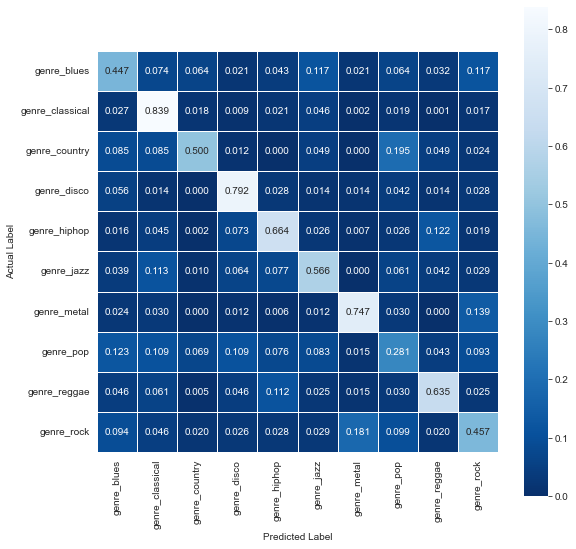

In [154]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass

### Hyperparameter Tuning with GridSearch

In [131]:
param_grid = {'C' : [0.1,1,10,10,1000], 'gamma' : [1,0.1,0.01,0.001,0.0001], 'kernel' : ['rbf']}

In [133]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [134]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.113 total time=   5.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.115 total time=   5.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.106 total time=   5.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.111 total time=   4.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.104 total time=   4.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.099 total time=   4.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.233 total time=   4.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.224 total time=   4.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.279 total time=   4.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.256 total time=   4.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.099 total time=   4.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.115 total time=   6.0s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.106 total time=   5.3s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.111 total time=   5.3s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.104 total time=   5.2s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.099 total time=   4.9s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.099 total time=   4.9s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.102 total time=   5.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.111 total time=   5.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.102 total time=   5.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.145 total time=   5.2s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.189 total time=   5.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.159 total time=   5.1s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 10, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [135]:
grid.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

In [137]:
grid.best_estimator_

SVC(C=10, gamma=0.0001)

In [173]:
#Making predictions with the hypertuned parameters
grid_predictions = grid.predict(X_test)

In [184]:
make_classification_report(
    y_true=y_test,
    y_pred=grid_predictions,
    model=grid,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.13    0.47      0.21       94  0.22
  genre_classical       0.84    0.82      0.83     1055  0.77
    genre_country       0.23    0.62      0.34       82  0.36
      genre_disco       0.22    0.82      0.35       72  0.41
     genre_hiphop       0.67    0.65      0.66      425  0.62
       genre_jazz       0.49    0.59      0.53      311  0.50
      genre_metal       0.43    0.79      0.56      166  0.56
        genre_pop       0.65    0.33      0.43     1069  0.35
     genre_reggae       0.50    0.64      0.56      197  0.55
       genre_rock       0.70    0.48      0.57      800  0.51
                                                             
         accuracy                         0.58     4271  0.52
        macro avg       0.49    0.62      0.50     4271      
     weighted avg       0.65    0.58      0.59     4271      
        

### High Level Results:

Balanced Accuracy: 0.58 \
MCC: 0.52 \
Macro Average f1: 0.50

### Confusion Matrix for Hypertuned Parameters:

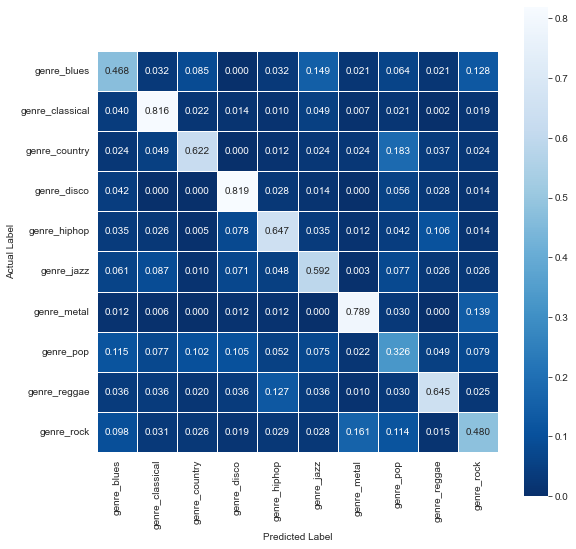

In [186]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=grid_predictions,
    model=grid,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass

### Polynomial Kernel SVM Model

In [178]:
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train, y_train)

SVC(degree=8, kernel='poly')

In [179]:
y_pred = svclassifier.predict(X_test)

In [181]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=svclassifier,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

                   precision  recall  f1-score  support    mcc
                                                              
      genre_blues       0.00    0.00      0.00       94  -0.01
  genre_classical       0.93    0.28      0.43     1055   0.45
    genre_country       0.50    0.05      0.09       82   0.15
      genre_disco       0.26    0.19      0.22       72   0.22
     genre_hiphop       0.19    0.01      0.02      425   0.02
       genre_jazz       0.47    0.02      0.04      311   0.09
      genre_metal       0.61    0.12      0.20      166   0.26
        genre_pop       0.40    0.00      0.00     1069   0.01
     genre_reggae       0.59    0.07      0.12      197   0.19
       genre_rock       0.21    0.97      0.34      800   0.13
                                                              
         accuracy                         0.27     4271   0.19
        macro avg       0.42    0.17      0.15     4271       
     weighted avg       0.49    0.27      0.20     4271

### High Level Results:

Balanced Accuracy: 0.27 \
MCC: 0.19 \
Macro Average f1: 0.15

### Confusion Matrix:

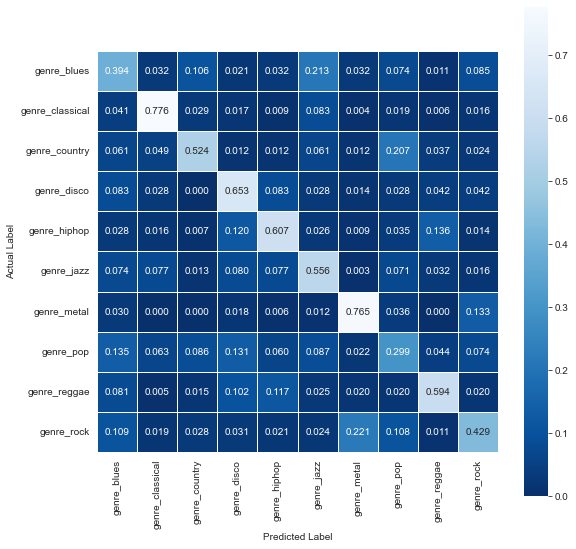

In [211]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=svclassifier,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass

### Sigmoid SVM Kernel Model

In [188]:
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [189]:
y_pred = svclassifier.predict(X_test)

In [191]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=svclassifier,
    x=X_test,
    label_encoder=le,
    print_report=True,
)
pass

                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.10    0.39      0.16       94  0.16
  genre_classical       0.87    0.78      0.82     1055  0.77
    genre_country       0.21    0.52      0.30       82  0.31
      genre_disco       0.14    0.65      0.23       72  0.28
     genre_hiphop       0.64    0.61      0.62      425  0.58
       genre_jazz       0.41    0.56      0.47      311  0.43
      genre_metal       0.37    0.77      0.50      166  0.50
        genre_pop       0.64    0.30      0.41     1069  0.33
     genre_reggae       0.46    0.59      0.52      197  0.50
       genre_rock       0.70    0.43      0.53      800  0.47
                                                             
         accuracy                         0.53     4271  0.47
        macro avg       0.45    0.56      0.46     4271      
     weighted avg       0.64    0.53      0.56     4271      
        

### High-Level Results:

Balanced Accuracy: 0.53 \
MCC: 0.47 \
Macro Average f1: 0.46

### Confusion Matrix:

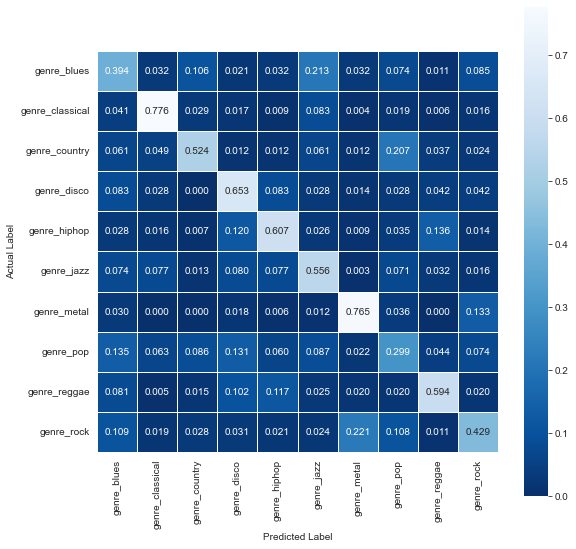

In [210]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=svclassifier,
    x=X_test,
    normalize="true",
    autoweight_sample=True,
    label_encoder=le,
    figsize=(9, 9),
)
pass